# Project: Stochastic Gradient Hamiltonian Monte Carlo

In this project we are going to implement standard HMC, HMC with MH, Naive SGHMC and SGHMC with Friction.

# standard HMC

### Basic settings

Suppose we want to sample from the posterior distribution: 
$$p(\theta|D) \propto exp(-U(\theta))$$ where $D = \{x_{1\:n}\}$
which are independent and $U$ is the potential energy fucntion: 
$$U = -\sum_{x_i \in D}\log p(x|\theta)- \log p(\theta)$$
We will sample from joint distribution $$\pi(\theta, r) \propto exp(-U(\theta)-\frac{1}{2}r^TM^{-1}r)$$
where r is the auxiliary momentum variables and M is the mass matrix. They define the kinetic energy together.
Then we discard r and keep $\theta$.

The Hamiltonian function is:
$$H(\theta, r)=U(\theta)+\frac{1}{2}r^TM^{-1}r$$
The Hamiltonian dynamics are:
$$d\theta = M^{-1}r dt\\ dr=-\triangledown U(\theta) dt$$

### Implement HMC

We use a univariate $\theta$ for illustration. Suppose $U(\theta)=-2\theta^2+\theta^4$. Based on $U(\theta)$, we need to define functions $\triangledown U, H$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la
import seaborn as sns

In [ ]:
from sghmc.sghmc.module import SGHMC_friction

In [ ]:
# need to be set manually
def U(theta):
    '''compute U'''
    
    return -2*theta**2 + theta**4

In [ ]:
# need to be set manually
def grad_U(theta):
    '''compute gradient of U'''
    
    return -4*theta+4*theta**3

In [ ]:
# need to be set manually
def set_M(theta):
    '''initialize M as identity with resonable dimensions based on theta, which is a np.array'''
    
    return np.eye(theta.shape[-1])

In [ ]:
# need to be set manually
def H(theta, r, M):
    '''compute Hamiltonian function'''
    assert M.shape[0]==M.shape[1], 'M is not a square matrix'
    
    return U(theta) + 1/2* r.T @ np.linalg.inv(M) @ r

In [ ]:
def std_HMC(theta0, epsilon, nmc, max_iteration):
    '''
    implement standard HMC
    theta0: np.array
    epsilon: float
    '''
    
    theta_post = [theta0]
    M = set_M(theta0)
    m = M.shape[0] # number of parameters
    
    i = 1
    while i < (nmc+1):
        r = ri = np.random.multivariate_normal(np.zeros(m), M).reshape(-1,1)
        
        theta= theta0
        
        #simulate discretization of Hamiltonian Dynamics
        r = r - epsilon * grad_U(theta)/2
        
        for j in range(max_iteration):
            theta = theta + epsilon * np.linalg.inv(M) @ r
            r = r - epsilon * grad_U(theta)
        
        # MH correction
        u = np.random.rand()
        ro = np.exp(H(theta, r, M) - H(theta_post[i-1], ri, M))
        if u < min(1,ro):
            theta_post.append(theta[0,0])
            i += 1
            
    return theta_post[1:]

In [ ]:
x = std_HMC(np.array([1]), 0.01, 1000, 100)

# Stochastic Gradient HMC with Naive Approach

The Naive approach refers to the simple plug-in estimator of $\triangledown \tilde{U}(\theta) = -\frac{|D|}{|\tilde{D}|}\sum_{x \in \tilde{D}} \triangledown log p(x|\theta) - \triangledown log p(\theta)$ with minibatch $\tilde{D}$. $\triangledown \tilde{U}(\theta)$ is computationally easier, but then the resulting joint distribution $\pi(\theta, r)$ is not invariant.

The Hamiltonian Dynamics are:
$$d\theta = M^{-1}r dt\\ dr=-\triangledown U(\theta) dt + N(0,2B(\theta)) dt$$
where $B(\theta) = \frac{1}{2}\epsilon V(\theta)$

# need to find covariance of the stochastic gradient noise

Since $\epsilon$ is small, it does not really matter that V is. Thus we take V as identity.

### Implement Naive SGHMC

# SGHMC with Friction

Add friction term to momentum update:
$$
d\theta = M^{-1}r dt\\
dr = - \triangledown U(\theta)dt - BM^{-1}rdt+N(0,2Bdt)
$$

# new proposal for SGHMC with friction

In [57]:
def SGHMC_friction(theta0, X, grad_logden_data, grad_logden_prior, V, eps, i, C, batch_size, M = None):
    '''
    SGHMC with friction:
    theta0(numpy array): starting position of theta (p,)
    X: data (n,m)
    grad_logden_data: gradient of the data log density (p,)
    grad_logden_prior: gradient of the prior log density (p,)
    V: estimated finsher information, (p,p)
    eps: step size
    i: number of iterations
    C: user specified friction term
    batch_size: size of minibatches
    M: Mass matrix
    '''
    
    def minib(x, batch_size):
        '''
        create minibatchs of x
        x: data
        batch_size: size of minibatch, if len(x)/batch_size is not integer, some batches wille have smaller sizes
        
        output: list of np.array of batchs [[batch_size,],...,[]]
        '''
        m = np.ceil(x.shape[0]/batch_size)
        np.random.shuffle(x)

        return np.array_split(x, m)
    
    def grad_U(grad_log_data, grad_log_prior, batch, theta, n):
        '''compute the gradient of U of batch'''
        
        return -(n*grad_log_data(batch,theta)/batch.shape[0]+grad_log_prior(theta))
    
    n, m = X.shape
    p = theta0.shape[0] # dim of theta
    
    # samples
    thetat = np.zeros((i+1,p)) # (#samples,p)
    thetat[0] = theta0 # set initial
    batch = minib(X, batch_size) # m-list of (batch_size,)
    m = len(batch)
    B = 1/2*eps*V
    
    
    if(M is None):
        M = np.eye(p)
    
    for t in range(i):
        ri = np.random.multivariate_normal(np.zeros(p), M)
        thetai = thetat[t]
        for j in range(m):
            bat = batch[j] # batch_j
            thetai = thetai + eps * np.linalg.inv(M) @ ri
            gU = grad_U(grad_logden_data,grad_logden_prior,bat,thetai,n)
            ri = ri - eps * gU - eps * C @ ri + la.sqrtm(2*(C-B)*eps) @ np.random.multivariate_normal(np.zeros(p), M)
        thetat[t+1] = thetai + eps * np.linalg.inv(M) @ ri
    
    return thetat[200:thetat.shape[0]]
        

In [49]:
def SGHMC_friction(theta0, X, grad_logden_data, grad_logden_prior, V, eps, i, C, batch_size, M = None):
    '''
    SGHMC with friction:
    theta0(numpy array): starting position of theta (p,)
    X: data (n,m)
    grad_logden_data: gradient of the data log density (p,)
    grad_logden_prior: gradient of the prior log density (p,)
    V: estimated finsher information, (p,p)
    eps: step size
    i: number of iterations
    C: user specified friction term
    batch_size: size of minibatches
    M: Mass matrix
    '''
    
    def minib(x, batch_size):
        '''
        create minibatchs of x
        x: data
        batch_size: size of minibatch, if len(x)/batch_size is not integer, some batches wille have smaller sizes
        
        output: list of np.array of batchs [[batch_size,],...,[]]
        '''
        m = np.ceil(x.shape[0]/batch_size)
        np.random.shuffle(x)

        return np.array_split(x, m)
    
    def grad_U(grad_log_data, grad_log_prior, batch, theta, n):
        '''compute the gradient of U of batch'''
        
        return -(n*grad_log_data(batch,theta)/batch.shape[0]+grad_log_prior(theta))
    
    n, m = X.shape
    p = theta0.shape[0] # dim of theta
    
    # samples
    thetat = np.zeros((i+1,p)) # (#samples,p)
    thetat[0] = theta0 # set initial
    batch = minib(X, batch_size) # m-list of (batch_size,)
    m = len(batch)
    B = 1/2*eps*V
    
    sqm = np.linalg.cholesky(2*(C-B)*eps)
    
    if(M is None):
        M = np.eye(p)
    
    for t in range(i):
        ri = np.random.multivariate_normal(np.zeros(p), M)
        thetai = thetat[t]
        for j in range(m):
            bat = batch[j] # batch_j
            thetai = thetai + eps * np.linalg.inv(M) @ ri
            gU = grad_U(grad_logden_data,grad_logden_prior,bat,thetai,n)
            ri = ri - eps * gU - eps * C @ ri + sqm @ np.random.normal(size=p)
        thetat[t+1] = thetai + eps * np.linalg.inv(M) @ ri
    
    return thetat[200:thetat.shape[0]]
        

In [58]:
def grad_logden_data(x,theta):
    return -(-4*theta+4*theta**3)/50

In [59]:
def grad_prior(theta):
    return 0

In [60]:
np.zeros(1)

array([0.])

In [79]:
theta = SGHMC_friction(theta0 = np.array([0]),X = np.zeros((50,1)),grad_logden_data = grad_logden_data,grad_logden_prior = grad_prior,
                V = np.eye(1)*0, eps=0.1,i=2000,C=2*np.eye(1),batch_size = 10)

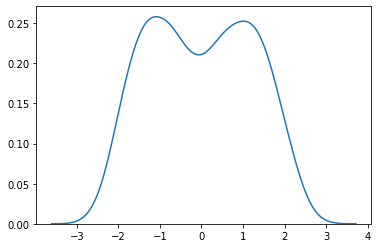

In [80]:
sns.kdeplot(theta[:,0])

## take simulated data from normal distribution as example

Simulate 1000 samples from N($\mu=10$,100). We want to sample $\mu$ from the posterior $p(\mu|D)$.

In [55]:
x = np.random.normal(10,10,1000)

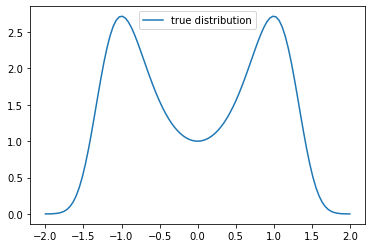

In [56]:
theta = np.linspace(-2,2,100)
p = np.exp(2*theta**2-theta**4)
fig, ax = plt.subplots()
ax.plot(theta,p,label = "true distribution")
ax.legend(loc= "upper center")

# 2nd example of mixture normal

Suppose we want to sample $x \sim 0.5N(5,1)+0.5N(-5,1)$. We want to sample from SGHMC.

In [12]:
mu = np.array([5, -5]).reshape(2,1)
nmc = 200
x = np.r_[np.random.normal(mu[0], 1, nmc),np.random.normal(mu[1], 1, nmc)]

In [13]:
# define gradient of log p(x|theta)
def grad_log_p(x, mu):
    '''compute gradient of log p(x|theta)'''
    
    #gd = np.c_[x-mu[0], x-mu[1]]
    #return np.sum(gd, axis = 0)
    exp1=np.exp(-0.5*(x-mu[0])**2)
    exp2=np.exp(-0.5*(x-mu[1])**2)
    
    v = np.c_[exp1*(x-mu[0]),exp2*(x-mu[1])]
    return np.sum(v/(exp1+exp2),axis=0)

# define gradient of log prior of theta
def grad_log_prior(mu):
    '''compute gradient of log prior'''
    
    return -(np.sum(mu)/10)

In [14]:
sim_mn = SGHMC_friction(theta0=np.array([1,1]), X = x[:,None], grad_logden_data=grad_log_p, grad_logden_prior=grad_log_prior, V=np.eye(2), eps=0.01, i=5000, C=np.eye(2), batch_size=50)

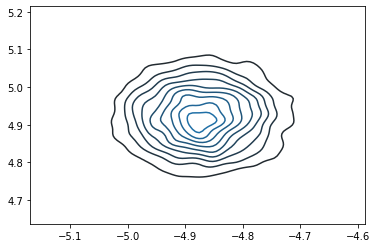

In [15]:
kdeplt2 = sns.kdeplot(sim_mn[:,0],sim_mn[:,1]) 

# HMC in linear model

In [148]:
# simulated results for linear model, n = #{obs} = 100, p = 4 (p*p X matrix), s2 = 1, coef = [1,2,3,4]^T
n, p = 100, 4
s2 = 1
X = np.c_[np.random.normal(size=n), np.random.normal(size=n), np.random.normal(size=n)]
noise = np.random.normal(size=n).reshape(-1,1)
beta = np.array([2,3,4]).reshape(-1,1)
alpha = 1

Y = X @ beta + alpha + noise

In [250]:
# set up priors for elements in beta and s2
alpha_prior_m = 0
alpha_prior_sd = 10

beta_prior_m = 0
beta_prior_sd = 10

logs2_prior_m = 0
logs2_prior_sd = 2

data = np.c_[Y,X]

In [267]:
def logposterior(parameter, data, alpha_prior_m=0, alpha_prior_sd=1, beta_prior_m=0, beta_prior_sd=1, logs2_prior_m=0, logs2_prior_sd=1):
    '''
    
    Compute the log density of data and gradient of log density of data
    Parameter: beta and log variance (p+1,1)
    X: data matrix (n,p)
    Y: response (n,1)
    ..._prior_m = prior mean of elts in parameters
    ..._prior_sd = prior standard error of elts in parameters
    
    '''
    
    def normal_prior(p, mu, s):
        '''compute the log prior and gradient of log prior'''
        Z = (p-mu)/s
        logpdf = np.sum(-np.log(s) - 0.5*np.log(2*np.pi)-0.5*Z**2, axis=0)
        grad_logpdf = -Z/s
        
        return logpdf.reshape(-1,1), grad_logpdf.reshape(-1,1)
    
    Y = data[:,0].reshape(-1,1)
    X = data[:,1:]
    
    alpha = parameter[0]
    beta = parameter[1:parameter.shape[0]-1]
    beta = beta.reshape(-1,1)
    logs2 = parameter[parameter.shape[0]-1]
    
    # compute log likelihood and gradient
    sigma = np.sqrt(np.exp(logs2))
    mu = X @ beta + alpha
    Z = (Y-mu)/sigma
    
    loglik = np.sum(-np.log(sigma)-0.5*np.log(2*np.pi)-0.5*Z**2)
    
    grad_alpha1 = np.sum(Z/sigma)
    grad_beta1 = X.T @ Z/sigma
    grad_logs21 = np.sum(-0.5 + 0.5*Z**2)
    
    # compute log priors and gradient
    log_prior_alpha, grad_lp_alpha = normal_prior(alpha, alpha_prior_m, alpha_prior_sd)
    log_prior_beta, grad_lp_beta = normal_prior(beta, beta_prior_m, beta_prior_sd)
    log_prior_logs2, grad_lp_logs2 = normal_prior(logs2, logs2_prior_m, logs2_prior_sd)
    log_prior = log_prior_alpha + log_prior_beta + log_prior_logs2 # '+' in matlab
    
    # log posterior and gradient
    log_post = loglik + log_prior
    grad_alpha = grad_alpha1 + grad_lp_alpha
    grad_beta = grad_beta1 + grad_lp_beta
    grad_logs2 = grad_logs21 + grad_lp_logs2
    grad_log_post = np.r_[grad_alpha, grad_beta, grad_logs2].reshape(-1,1)
    
    return grad_log_post

In [268]:
glp = logposterior(np.array([1,2,3,4,2]), data, alpha_prior_m, alpha_prior_sd, beta_prior_m, beta_prior_sd, logs2_prior_m, logs2_prior_sd)

In [269]:
glp

array([[  1.91344269],
       [ -2.20155194],
       [ -1.21357864],
       [  0.5563807 ],
       [-42.76933966]])

In [284]:
# try linear model hmc
def SGHMC_friction2(theta0, X, grad_logden_data, grad_logden_prior, eps, i, B, C, batch_size,burnin,seed=1, M = None):
    '''
    SGHMC with friction:
    theta0(numpy array): starting position of theta
    X: data
    grad_logden_data: gradient of the data log density
    grad_logden_prior: gradient of the prior log density
    eps: step size
    i: number of iterations
    B: noise estimate
    C: user specified friction term
    batch_size: size of minibatches
    M: Mass matrix
    '''
    
    def minib(x, batch_size):
        '''
        create minibatchs of x
        x: data
        batch_size: size of minibatch, if len(x)/batch_size is not integer, some batches wille have smaller sizes
        '''
        m = np.ceil(x.shape[0]/batch_size)
        np.random.shuffle(x)

        return np.array_split(x, m)
    
    n = theta0.shape[0]
    rt = np.zeros((i+1,n))
    thetat = np.zeros((i+1,n))
    thetat[0,:] = theta0
    batch = minib(X,batch_size)
    m = len(batch)

    if(M is None):
        M = np.eye(n)
    
    for t in range(i):
        rt[t,:] = np.random.multivariate_normal(np.zeros(n), M)
        theta0,r0 = thetat[t,:],rt[t,:]
        thetai,ri = theta0.reshape(-1,1),r0.reshape(-1,1)
        for j in range(m):
            thetai = thetai + eps * np.linalg.inv(M) @ ri
            gU = - X.shape[0]/batch[j].shape[0]* logposterior(thetai, batch[j])
            ri = ri - eps * gU.reshape(-1,1) - eps * C @ np.linalg.inv(M) @ ri + np.random.multivariate_normal(np.zeros(n), np.array(2*eps*(C-B)).reshape(n,n)).reshape(-1,1)
        thetat[t+1,:],rt[t+1,:] = thetai.reshape(-1,n), ri.reshape(-1,n)
    
    return thetat[burnin+1:,],rt[burnin+1:,:]

In [288]:
a,b = SGHMC_friction2(np.array([1,2,3,4,2]), data, grad_logden_data, grad_logden_prior, 0.01, 2000, 0*np.eye(5), np.eye(5), batch_size=20,burnin=100,seed=1, M = None)

In [289]:
a.shape

(1900, 5)

In [290]:
np.mean(a,axis=0)

array([1.07031217, 1.84082497, 2.78347437, 3.96260467, 0.25293734])